In [4]:
import numpy as np
from data_preprocess import load_ratings_data, Environment
from scipy.sparse import csc_matrix
from scipy.stats import multivariate_normal, norm

In [5]:
file_path = "./ml-100k"

ratings, full_users, full_movies = load_ratings_data(file_path, [0, 1])
initial_ratings, _, _ = load_ratings_data(file_path, [0.0, -0.1], full_users, full_movies)
# centerize
ratings.data = ratings.data - 3
initial_ratings.data = initial_ratings.data - 3

In [7]:
class RandomRecommendation():
    def __init__(self, N_user, N_item):
        self.N_user = N_user
        self.N_item = N_item
    
    def predict(self, user_id, options, prev_rewards):
        return np.random.choice(options)
    
    def update(self, user_id, item_id, rating):
        pass


class NaiveEpsilonGreedy():
    def __init__(self, N_user, N_item, epsilon=0.1):
        self.epsilon = epsilon
        self.N_user = N_user
        self.N_item = N_item
        self.item_sum = np.zeros(N_item)
        self.item_count = np.zeros(N_item, dtype=np.int64) 
    
    def predict(self, user_id, options, prev_rewards):
        if np.random.rand() < self.epsilon:
            return np.random.choice(options)
        else:
            item_sum = self.item_sum[options]
            item_count = self.item_count[options]
            est_rating = np.where(item_count > 0, item_sum / item_count, 0) 
            est_rating = est_rating + np.random.randn(len(est_rating)) * 1e-4 #(to break a tie)
            return options[np.argmax(est_rating)]
    
    def update(self, user_id, item_id, rating):
        self.item_sum[item_id] += rating
        self.item_count[item_id] += 1


class PTS():
    def __init__(self, N_user, N_item, D, N_particles, sigma=0.5):
        self.D = D
        self.N_particles = N_particles
        self.w = np.ones(N_particles) / N_particles
        self.item_features = np.zeros((N_particles, N_item, D))
        self.user_features = np.zeros((N_particles, N_user, D))
        self.sigma = 0.5
        # The ratings is saved as row-sparse matrix, so in order to track column/item history, 
        # we need to save them separately.
        self.item_rating_history = csc_matrix((N_user, N_item), dtype=np.float64)    
        
    def predict(self, user_id, options, prev_rewards):
        # Find all viewed movies
        prev_idx = prev_rewards[user_id].indices

        # Sample a particle
        particle = np.random.choice(self.N_particles, p=self.w)
        # Sample from P(User_i| Items, ratings) (and cache for update)
        self.precision, self.xi = self.conditioning(prev_idx, prev_rewards[user_id].data)
        self.user_Sigma = np.linalg.inv(self.precision)
        self.user_mu = self.sigma ** (-2) * self.user_Sigma @ self.xi[particle]
        self.user_mu = self.user_mu.squeeze()
        # Form the decision vector
        item_v = self.item_features[particle, options]
        user_v = np.random.multivariate_normal(self.user_mu[particle], self.user_Sigma[particle])
        # Estimate the best movie
        x = item_v @ user_v
        recommendation = options[np.argmax(item_v @ user_v)]
        return recommendation
    
    # Calculate P^{(d)}(U_i| V^{(d)}) = N(mu^{(d)}, Sigma^{(d)})
    def conditioning(self, prev_idx, rewards):
        item_v = self.item_features[:, prev_idx]
        precision = self.sigma ** (-2) * item_v.swapaxes(1,2) @ item_v + np.eye(self.D)[None, :, :]
        xi =  item_v.swapaxes(1,2) @ rewards[:, None]
        return precision, xi

    def update(self, user_id, item_id, rating):
        # update column rating history
        self.item_rating_history += csc_matrix(([rating], ([user_id], [item_id])),
                                shape=self.item_rating_history.shape, dtype=np.float64)
        item_v_new = self.item_features[:, item_id]
        # reweight the particles
        rating_mu = (item_v_new * self.user_mu).sum(axis=1)
        rating_sig = self.sigma**2 + item_v_new[:, None, :] @ self.user_Sigma @ item_v_new[:, :, None]
        rating_sig = rating_sig.squeeze()
        self.w = norm.pdf(rating, loc=rating_mu, scale=np.sqrt(rating_sig))
        self.w /= self.w.sum()

        # resample the particles
        new_particles = np.random.choice(self.N_particles, self.N_particles, p=self.w)
        item_v_new = item_v_new[new_particles]
        self.precision = self.precision[new_particles]
        self.xi = self.xi[new_particles]
        self.user_features = self.user_features[new_particles]
        self.item_features = self.item_features[new_particles]
        self.w = np.ones(self.N_particles) / self.N_particles
        # resample user_i
        self.precision += self.sigma ** (-2) * item_v_new[:, :, None] @ item_v_new[:, None, :]
        self.xi += item_v_new[:, :, None] * rating
        user_Sigma = np.linalg.inv(self.precision)
        user_mu = self.sigma ** (-2) * user_Sigma @ self.xi
        user_mu = user_mu.squeeze()
        
        user_v = [np.random.multivariate_normal(user_mu[i], user_Sigma[i]) for i in range(self.N_particles)]
        self.user_features[:, user_id] = np.stack(user_v)
        # resample item_j
        item_history = self.item_rating_history[:, item_id].indices
        rewards = self.item_rating_history[:, item_id].data
        user_v = self.user_features[:, item_history]
        item_Sigma = np.linalg.inv(self.sigma ** (-2) * user_v.swapaxes(1,2) @ user_v + np.eye(self.D)[None, :, :])
        item_mu =  self.sigma ** (-2) * item_Sigma @ user_v.swapaxes(1,2) @ rewards[:, None]
        item_mu = item_mu.squeeze()
        item_v = [np.random.multivariate_normal(item_mu[i], item_Sigma[i]) for i in range(self.N_particles)]
        self.item_features[:, item_id] = np.stack(item_v)



In [9]:
from tqdm import tqdm


def experiment(Horizon, model, env):
    users = set(range(env.gt_rating.shape[0]))
    acc_regret = [0]
    bar = tqdm(range(Horizon))
    for i in bar:
        user_id = np.random.choice(list(users))
        options = env.option(user_id)
        if len(options) / env.gt_rating[user_id].count_nonzero() < 0.5:
        # Assume the rest of the movie doesn't worth recommendation
            users.remove(user_id)
            continue 
        recommend_id = model.predict(user_id, options, env.prev_rating)
        gt_rating, regret = env.update(user_id, recommend_id)
        model.update(user_id, recommend_id, gt_rating)
        acc_regret.append(acc_regret[-1] + regret)
        if i > 100:
            bar.set_description(f"avg regret: {(acc_regret[-1]-acc_regret[-100])/100:.4f}")
    return acc_regret


In [10]:
Horizon = 30000
results = {}

In [11]:
env = Environment(ratings, initial_ratings, replace=True)
model = RandomRecommendation(ratings.shape[0], ratings.shape[1])
results["random"] = experiment(Horizon, model, env)

avg regret: 1.4300: 100%|██████████| 30000/30000 [00:54<00:00, 554.12it/s]


In [12]:
env = Environment(ratings, initial_ratings, replace=True)
model = NaiveEpsilonGreedy(ratings.shape[0], ratings.shape[1])
results["e-greedy"] = experiment(Horizon, model, env)

  0%|          | 0/30000 [00:00<?, ?it/s]C:\Users\a2576\AppData\Local\Temp\ipykernel_20320\2048948020.py:27: RuntimeWarning: invalid value encountered in divide
  est_rating = np.where(item_count > 0, item_sum / item_count, 0)
avg regret: 0.7700: 100%|██████████| 30000/30000 [00:52<00:00, 574.89it/s]


In [13]:
env = Environment(ratings, initial_ratings, replace=True)
model = PTS(ratings.shape[0], ratings.shape[1], 2, 30)
results["pts"] = experiment(Horizon, model, env)

avg regret: 0.3700: 100%|██████████| 30000/30000 [03:42<00:00, 134.60it/s]


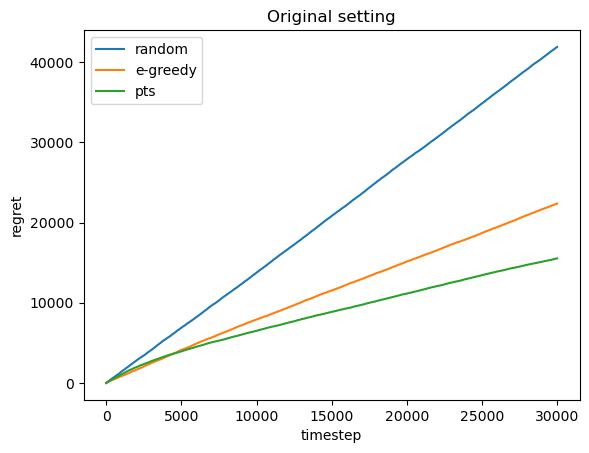

In [14]:
from matplotlib import pyplot as plt

plt.title("Original setting")
plt.plot(results["random"], label="random")
plt.plot(results["e-greedy"], label="e-greedy")
plt.plot(results["pts"], label="pts")

plt.legend()
plt.xlabel("timestep")
plt.ylabel("regret")
plt.savefig("original.png", dpi=200)

  0%|          | 0/30000 [00:00<?, ?it/s]C:\Users\a2576\AppData\Local\Temp\ipykernel_20320\2048948020.py:27: RuntimeWarning: invalid value encountered in divide
  est_rating = np.where(item_count > 0, item_sum / item_count, 0)
avg regret: 1.2400: 100%|██████████| 30000/30000 [03:35<00:00, 139.21it/s]


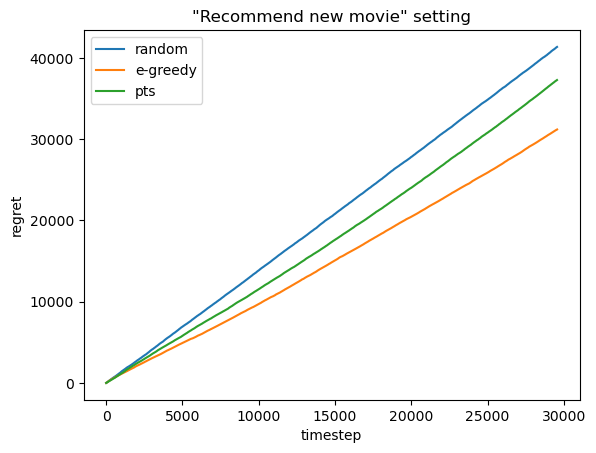

In [15]:
Horizon = 30000
results = {}


env = Environment(ratings, initial_ratings, replace=False)
model = RandomRecommendation(ratings.shape[0], ratings.shape[1])
results["random"] = experiment(Horizon, model, env)

env = Environment(ratings, initial_ratings, replace=False)
model = NaiveEpsilonGreedy(ratings.shape[0], ratings.shape[1])
results["e-greedy"] = experiment(Horizon, model, env)

env = Environment(ratings, initial_ratings, replace=False)
model = PTS(ratings.shape[0], ratings.shape[1], 2, 30)
results["pts"] = experiment(Horizon, model, env)


plt.title("\"Recommend new movie\" setting")
plt.plot(results["random"], label="random")
plt.plot(results["e-greedy"], label="e-greedy")
plt.plot(results["pts"], label="pts")

plt.legend()
plt.xlabel("timestep")
plt.ylabel("regret")
plt.savefig("new_movies.png", dpi=200)